<a href="https://colab.research.google.com/github/twyeh/university-physics/blob/%E9%9B%BB%E7%A3%81%E5%AD%B8/%E9%95%B7%E6%96%B9%E5%BD%A2%E5%9D%87%E5%8B%BB%E9%9D%A2%E5%B8%B6%E9%9B%BB%E9%AB%94%E7%9A%84%E9%9B%BB%E5%A0%B4%E7%A9%BA%E9%96%93%E5%88%86%E5%B8%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:140: SyntaxWarning: invalid escape sequence '\s'
<>:140: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-13007065.py:140: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f'3D Electric Field of a Charged Plate ($\sigma={plane_sigma}$ C/m$^2$)\na={A_length}m, b={B_width}m')


長方形尺寸: a=0.5m, b=0.5m
離散點數: N_x=20, N_y=20 (總共 400 個點電荷)
計算網格點數量: 512


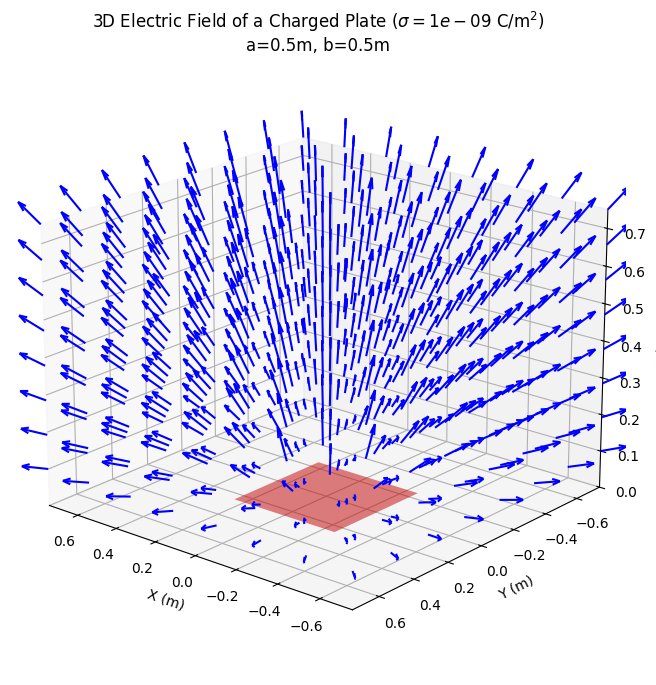

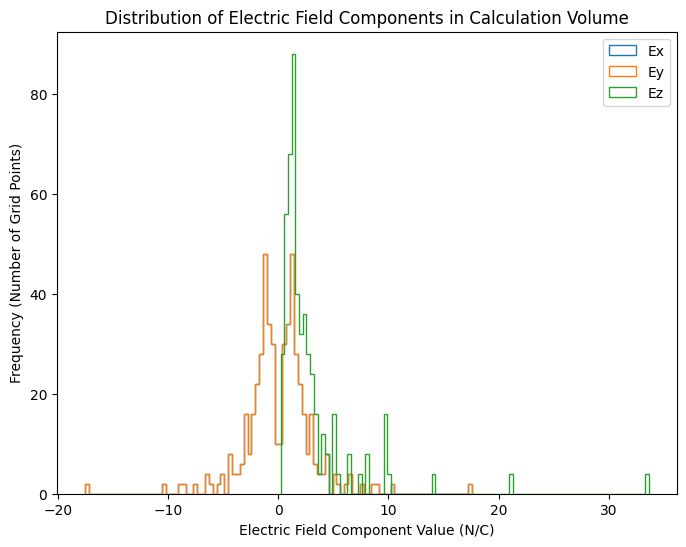

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 導入 3D 繪圖模組

# 物理常數
K = 8.9875e9  # 庫侖常數 $k = 1 / (4\pi\epsilon_0)$ (N m^2 / C^2)

def electric_field_point_charge(q, r_source, r_field):
    """
    計算單一點電荷在 r_field 處產生的電場 E。
    r_source 為 (3,)，r_field 可為 (N, 3)。
    """
    R = r_field - r_source
    R_mag_sq = np.sum(R**2, axis=-1)

    mask = R_mag_sq > 1e-18

    E = np.zeros_like(R)

    if R.ndim == 1:
        if mask:
            R_mag = np.sqrt(R_mag_sq)
            E = K * q * R / (R_mag**3)
    else:
        R_mag = np.sqrt(R_mag_sq)
        factor = np.zeros_like(R_mag_sq)
        factor[mask] = K * q / (R_mag[mask]**3)
        E = R * factor[:, np.newaxis]

    return E

def calculate_E_at_points(sigma, x_min, x_max, y_min, y_max, plane_z, N_x, N_y, r_field_points):
    """
    計算均勻帶電矩形平面（通過離散化為 N_x * N_y 個點電荷）在多個空間點產生的總電場。
    回傳: (N, 3) 陣列，總電場向量。
    """

    dx = (x_max - x_min) / N_x
    dy = (y_max - y_min) / N_y
    dA = dx * dy
    dq = sigma * dA  # 每個微小點電荷的電量

    x_sources = np.linspace(x_min + dx/2, x_max - dx/2, N_x)
    y_sources = np.linspace(y_min + dy/2, y_max - dy/2, N_y)

    X_s, Y_s = np.meshgrid(x_sources, y_sources)
    N_s = N_x * N_y
    r_sources = np.stack([X_s.flatten(), Y_s.flatten(), np.full(N_s, plane_z)], axis=1)

    E_total = np.zeros(r_field_points.shape)

    for r_source in r_sources:
        E_d = electric_field_point_charge(dq, r_source, r_field_points)
        E_total += E_d

    return E_total


# --- 模擬參數設定 ---
# 1. 長方形尺寸 (長 $a$ 沿 $x$ 軸, 寬 $b$ 沿 $y$ 軸)
A_length = 0.5            # 長度 a (m)
B_width = 0.5             # 寬度 b (m)

plane_sigma = 1.0e-9      # 表面電荷密度 (C/m^2)
plane_z_coord = 0.0       # 平面 z 座標

# 2. 根據 a 和 b 計算座標範圍 (假設中心在原點)
plane_x_min = -A_length / 2
plane_x_max = A_length / 2
plane_y_min = -B_width / 2
plane_y_max = B_width / 2

# 3. 離散化點數 (計算精度與速度的權衡)
N_x = 20
N_y = 20
print(f"長方形尺寸: a={A_length}m, b={B_width}m")
print(f"離散點數: N_x={N_x}, N_y={N_y} (總共 {N_x * N_y} 個點電荷)")


# --- 計算區域設定 (創建 3D 網格) ---
Range = 0.75
X_min_calc, X_max_calc = -Range, Range
Y_min_calc, Y_max_calc = -Range, Range
Z_min_calc, Z_max_calc = 0.1, Range  # 避免 Z=0 附近產生極強的場

n_points_3d = 8  # 3D 網格每個維度的點數 (例如 8x8x8=512 個計算點)

x_vals = np.linspace(X_min_calc, X_max_calc, n_points_3d)
y_vals = np.linspace(Y_min_calc, Y_max_calc, n_points_3d)
z_vals = np.linspace(Z_min_calc, Z_max_calc, n_points_3d)

X_grid, Y_grid, Z_grid = np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')

r_field_points = np.stack([X_grid.flatten(), Y_grid.flatten(), Z_grid.flatten()], axis=1)

print(f"計算網格點數量: {r_field_points.shape[0]}")


# --- 執行計算 ---
E_total_vectors = calculate_E_at_points(
    plane_sigma, plane_x_min, plane_x_max, plane_y_min, plane_y_max,
    plane_z_coord, N_x, N_y, r_field_points
)


# --- 提取分量 ---
E_X = E_total_vectors[:, 0]  # $E_x$ 分量
E_Y = E_total_vectors[:, 1]  # $E_y$ 分量
E_Z = E_total_vectors[:, 2]  # $E_z$ 分量

E_mag = np.linalg.norm(E_total_vectors, axis=1) # 總電場大小


# =================================================================
#                         圖形輸出 I: 3D 向量場
# =================================================================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.quiver(X_grid.flatten(), Y_grid.flatten(), Z_grid.flatten(),
          E_X, E_Y, E_Z,
          length=0.1,
          normalize=True,
          color='blue')

# 繪製帶電平面
plane_x_surface = np.linspace(plane_x_min, plane_x_max, 2)
plane_y_surface = np.linspace(plane_y_min, plane_y_max, 2)
X_surf, Y_surf = np.meshgrid(plane_x_surface, plane_y_surface)
Z_surf = np.full_like(X_surf, plane_z_coord)

ax.plot_surface(X_surf, Y_surf, Z_surf,
                color='red', alpha=0.5, label='Charged Plane')


# 設定座標軸標籤和標題
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title(f'3D Electric Field of a Charged Plate ($\sigma={plane_sigma}$ C/m$^2$)\na={A_length}m, b={B_width}m')

ax.set_xlim(X_min_calc, X_max_calc)
ax.set_ylim(Y_min_calc, Y_max_calc)
ax.set_zlim(plane_z_coord, Z_max_calc)
ax.view_init(elev=20, azim=130)

# =================================================================
#                         圖形輸出 II: 分量直方圖
# =================================================================
plt.figure(figsize=(8, 6))

# 使用提取出的一維陣列 E_X, E_Y, E_Z 進行直方圖繪製
# 注意: 在這裡 E_X, E_Y, E_Z 已經是 1D 陣列 (N_points,)，因此不需要 .ravel()
plt.hist(E_X, bins=100, histtype='step', label='Ex')
plt.hist(E_Y, bins=100, histtype='step', label='Ey')
plt.hist(E_Z, bins=100, histtype='step', label='Ez')

plt.legend()
plt.xlabel('Electric Field Component Value (N/C)')
plt.ylabel('Frequency (Number of Grid Points)')
plt.title('Distribution of Electric Field Components in Calculation Volume')

# 顯示所有圖形
plt.show()